# MOIRAI

[MOIRAI](https://arxiv.org/pdf/2402.02592) aims to be a unified training for U Time series forecasting.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes


from gluonts.dataset.split import split
import numpy as np
import torch
from einops import rearrange
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from gluonts.dataset.pandas import PandasDataset
from obspy.clients.fdsn import Client

import obspy

/Users/marinedenolle/GitHub/quakeLLM/src/uni2ts/src/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")


### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [2]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 368  # context length: any positive integer
PRED = 60  # prediction length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

### Prepare dataset

We will load an earthquake catalog using obspy.

In [3]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 6
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)
print(quake_catalog)

2 Event(s) in Catalog:
2019-07-06T03:19:53.040000Z | +35.770, -117.599 | 7.1  Mw | manual
2019-07-04T17:33:49.000000Z | +35.705, -117.504 | 6.4  Mw | manual


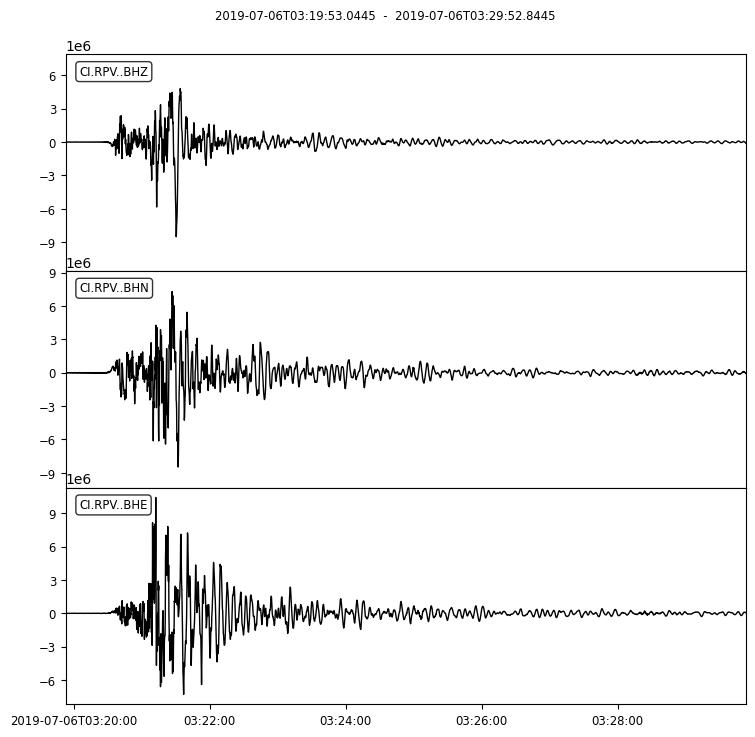

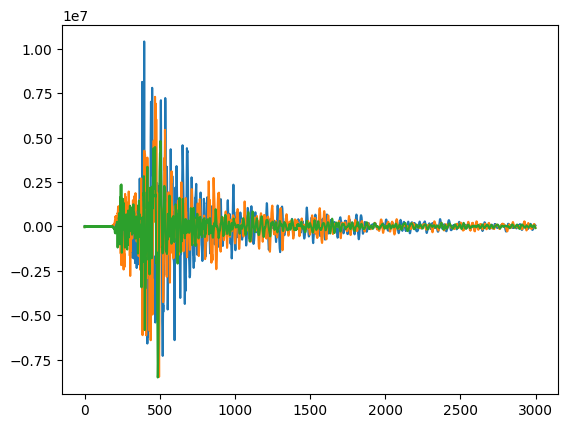

In [4]:
# get a seismogram from CI.RPV..BHZ for the large earthquake in the first element of quake_catalog
event = quake_catalog[0]
origin = event.origins[0]
# convert the origin time to a UTCDateTime object
event_time = obspy.UTCDateTime(origin.time)
z=client.get_waveforms("CI", "RPV", "", "BH*", event_time, event_time + 60*10)
# downsample to df Hz

df = 5
z.resample(df)
z.plot()
data = np.zeros(shape=(3, len(z[0].data)))
data[0] = z[0].data
data[1] = z[1].data
data[2] = z[2].data
plt.plot(data.T)


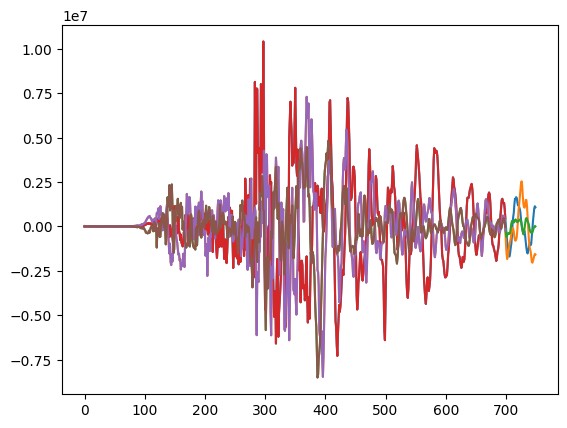

In [57]:
# now we are going to reshape the data into a format that can be used by the ChronosPipeline
# data = np.expand_dims(data, axis=0)
prediction_length = int(10*df)
last_date = int(160*df)
start_date = int(20*df)
#create a time vector with sampling rate df
CTX = last_date - start_date

plt.plot(data[:,start_date:last_date+prediction_length].T)
plt.plot(data[:,start_date:last_date].T);

In [9]:
#make a moirai compatible input data from the numpy array data
data = torch.tensor(data).float()

In [11]:
time

<module 'numpy' from '/Users/marinedenolle/opt/miniconda3/envs/quakellm/lib/python3.11/site-packages/numpy/__init__.py'>

In [12]:
# create a sample for the daily data, using 1 year data as context window and predicting the next 2 months.
inp = {
    "target": data[0, start_date:last_date],  
    "start": start_date,
}
label = {
    "target": data[0,last_date:last_date+prediction_length], 
    "start": last_date,
}

In [58]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=CTX,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values. Shape: (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1" # 1 batch, t time, 1 variate
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)


In [48]:
d ysadw6ant("Shape of past_observed_target:", past_observed_target.shape)
print("Shape of past_is_pad:", past_is_pad.shape)

Shape of past_target: torch.Size([1, 700, 1])
Shape of past_observed_target: torch.Size([1, 700, 1])
Shape of past_is_pad: torch.Size([1, 700])


In [59]:
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad)

RuntimeError: The size of tensor a (88) must match the size of tensor b (95) at non-singleton dimension 1

In [50]:
PRED

60

In [51]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[0], axis=0), decimals=1),
)
print("ground truth:\n", label["target"])

median prediction:
 [ -978998.9  -581344.4  -820777.1 -1176112.   -990797.2  -956250.1
  -963290.9 -1174191.5 -1161021.  -1222086.2  -881256.8 -1122600.8
  -468102.8 -1086643.  -1038053.1 -1600476.4 -1118548.8 -1053508.
 -1776452.4 -1181949.  -1501653.5 -1382674.6 -1235815.   -998767.6
 -1343710.8 -1374215.   -817125.8 -1033905.8 -1593953.8 -1087976.5
 -1577775.2 -1390487.5 -1063673.  -1199524.  -1541937.4 -1127619.1
 -1318406.8 -1078823.2 -1403501.  -1366358.9  -876096.  -1447719.2
  -779486.9 -1539784.8 -1195491.2 -1205486.2 -1617281.9 -1556280.9
 -1055165.2 -1243955.5]
ground truth:
 tensor([   26936.2559,  -453052.6250,  -835105.9375, -1088777.5000,
        -1411582.3750, -1663795.6250, -1693551.2500, -1494270.2500,
        -1196284.0000,  -963077.2500,  -540632.1250,   148243.9375,
          516344.4062,   754356.5625,  1226814.7500,  1555539.6250,
         1556498.0000,  1647952.5000,  1604301.3750,  1361001.5000,
         1191737.7500,  1187537.6250,  1099060.5000,   982942.2500

In [52]:
forecast[0][0].shape

torch.Size([50])

In [56]:
CTX

368

In [46]:
last_date, last_date+prediction_length, prediction_length,PRED

(800, 850, 50, 60)

50
50


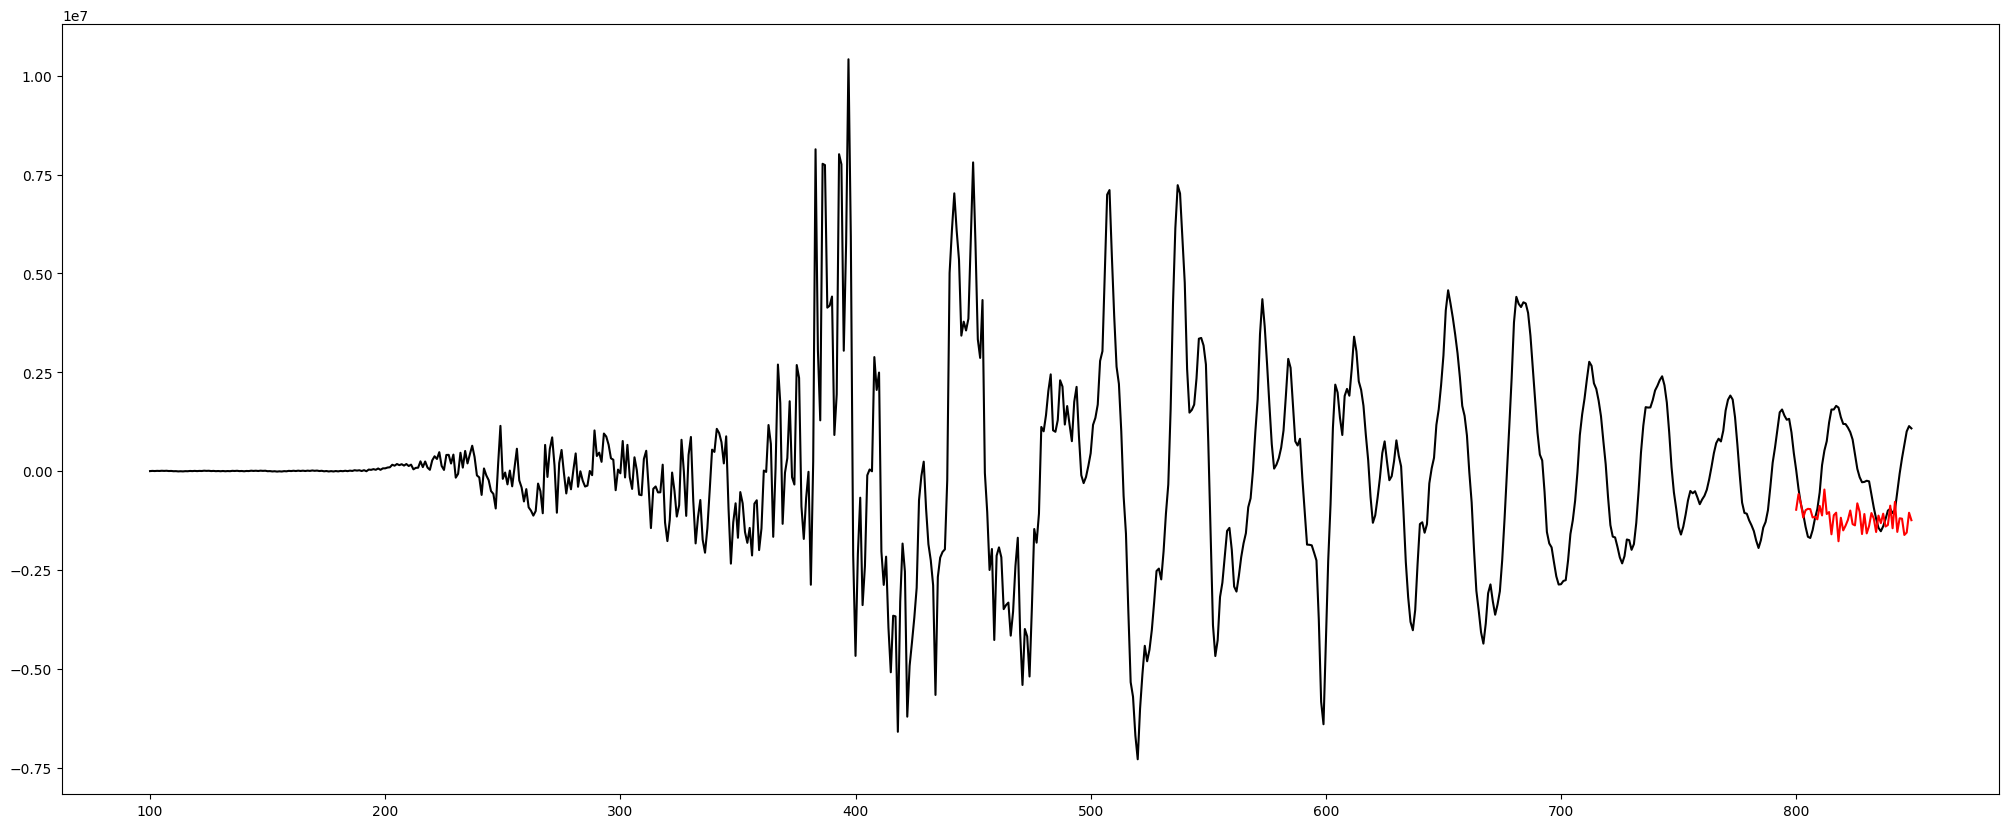

In [55]:
# now plot the input data, the ground thruth and the predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
t1 = np.arange(start_date, last_date+prediction_length)
t2 = np.arange(last_date, last_date + prediction_length)
print(len(np.median(forecast[0], axis=0)))
print(len(t2))
plt.plot(t1,data[0,start_date:last_date+prediction_length].T,'k')
plt.plot(t2,np.median(forecast[0], axis=0),'r')


## Rolling evaluation

In [ ]:
TEST = 100
PDT = PRED

In [ ]:
# Split into train/test set
train, test_template = split(
    dataset, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)



### Make predictions

In [ ]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

(0.0, 20.0)

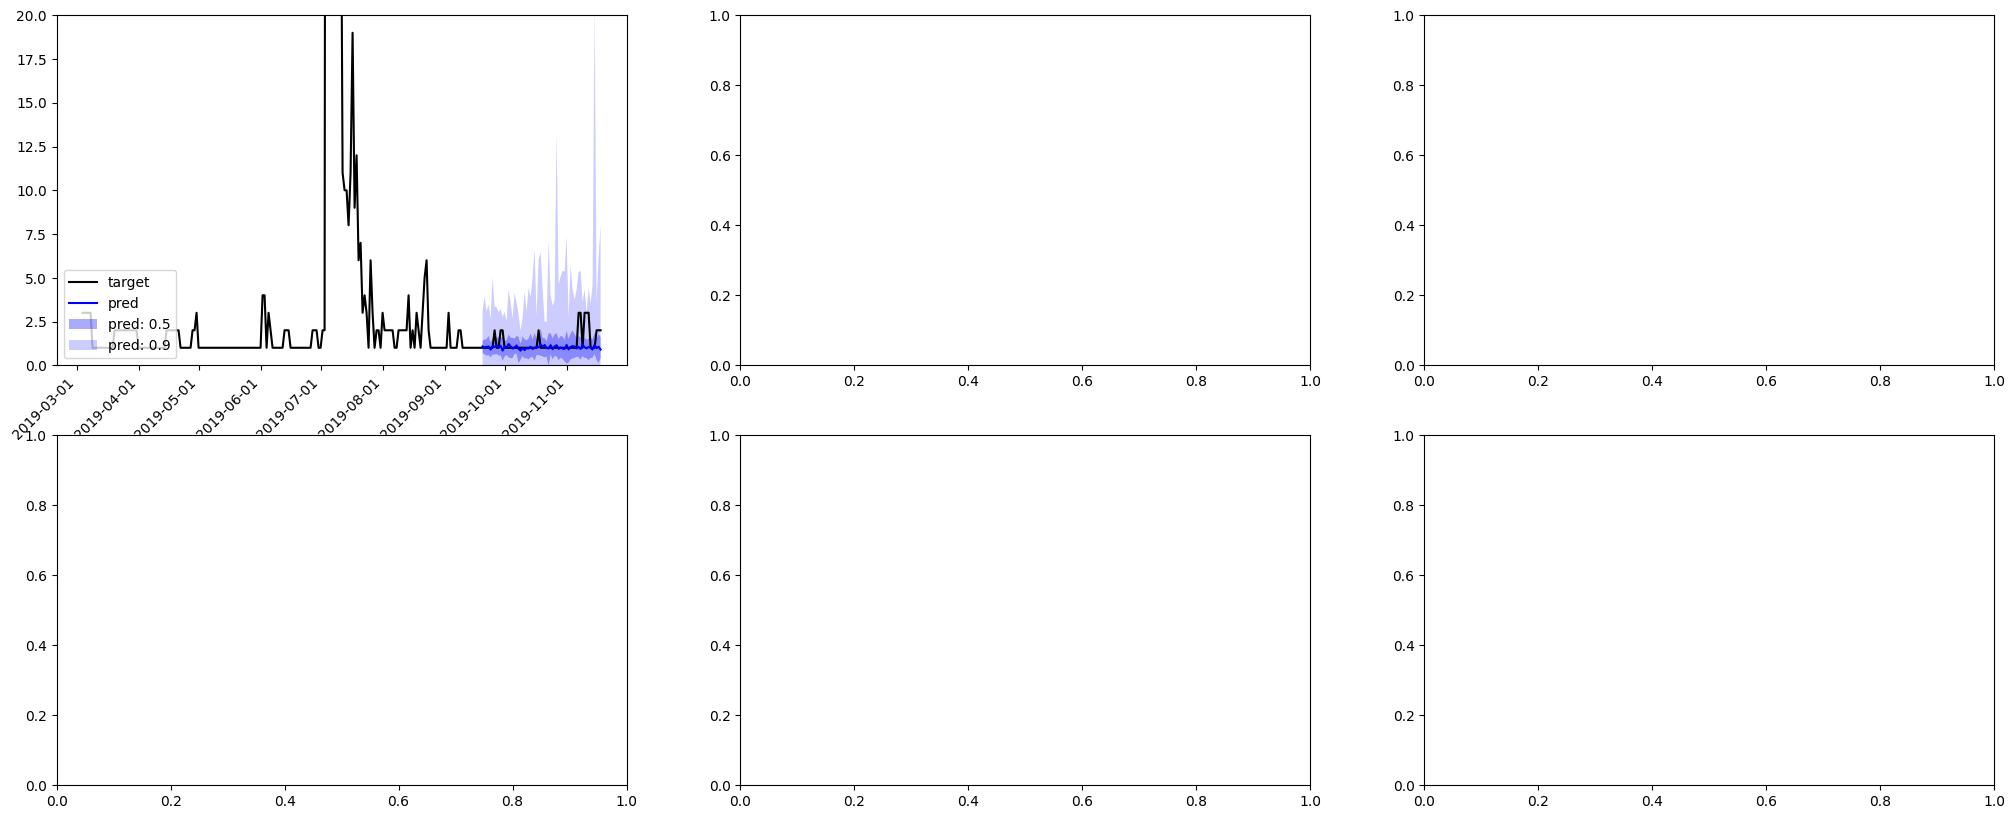

In [ ]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)
axes[0,0].set_ylim([0,20])